Utilities for collecting fitting results and generating plots of equivalent ICESat-2 profiles are in the make_composite_stats module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from make_composite_stats import setup, composite_stats
catalog=setup('SRF_green_full.h5', 'TEP.h5')

Text(0.5, 0, 'amplitude, scaled')

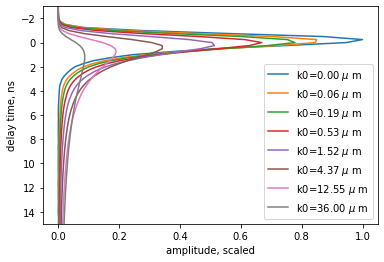

In [25]:
plt.figure(1); plt.clf()
for k0 in list(catalog)[::10]:
    plt.plot(catalog[k0].p, catalog[k0].t, label="k0=%4.2f $\mu$ m" %(k0*1000.))
plt.gca().set_ylim([15, -3])
plt.legend()
plt.ylabel('delay time, ns')
plt.xlabel('amplitude, scaled')

These correspond to window delays for a $\pm$ 1.5 m window for the median and mean:


(-0.6, 0.1)

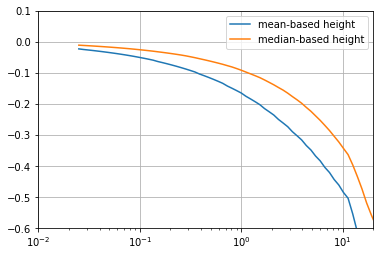

In [24]:
k0s=np.array(list(catalog))
means=np.array([composite_stats(catalog[k0], 20)[0] for k0 in k0s])
meds=np.array([composite_stats(catalog[k0], 20)[1] for k0 in k0s])

plt.figure(2); plt.clf()
plt.semilogx(k0s[1:]*1000, (means[1:]-means[0])*-.15, label='mean-based height')
plt.semilogx(k0s[1:]*1000, (meds[1:]-meds[0])*-.15, label='median-based height')
plt.grid()
plt.legend()
plt.gca().set_xlim([0.01, 20])
plt.gca().set_ylim([-0.6, 0.1])